In [1]:
import nltk
nltk.download('stopwords')
import numpy as np
import re
!pip install pandas
import pandas as pd
import pprint
np.random.seed(2059)

#Gensim
import gensim
import gensim.corpora as corpora
import gensim.utils
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import sklearn
from sklearn.feature_extraction.text import CountVectorizer

!pip install textblob
from textblob import TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import scipy.stats as stats

#spacy for lemmatization
import spacy
#spacy.cli.download("en_core_web_sm")
spacy.cli.download("en_core_web_md")

from gensim.corpora import Dictionary

#Import the wordcloud library
from wordcloud import WordCloud

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors


#plotting tools
!pip install pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['do','done', 'dont', 'didnt','doesnt', 'book', 'books', 'new', 'Kindle', 'kindles', 'Kindles', 'read', 'reading',
                   'ive', 'far', 'get', 'love', 'want', 'many', 'thank', 'well', 'gets', 'getting', 'gettings',
                   'im', 'go', 'great',                                                                                                                                                         'know', 'knew', 'knows', 'known', 'knowing', 'even', 'really', 'come', 'comes', 'take', 'takes',
                                                                                                                                                                                                'thing', 'things',  'use', 'used', 'uses', 'useful',

                                                                                                                                                                                                #0-9
                                                                                                                                                                                                'people', 'peoples', 'one', 'ones', 'id', 'open', 'opens', 'opened', 'opening',
                                                                                                                                                                                                'words', 'words', 'also', 'think', 'thinking', 'mine', 'mines', 'already',
                                                                                                                                                                                                'need', 'needs', 'needed', 'first', 'say', 'says', 'saying', 'get', 'got', 'gotta', 'gotten', 'tell', 'tells',
                                                                                                                                                                                                'much', 'turn', 'turns', 'turned', 'turning', 'never',
                                                                                                                                                                                                'way', 'ways', 'see', 'saw', 'seen', 'seek', 'seem', 'seems', 'semeingly', 'look', 'looks', 'looking', 'looked', 'lookup', 'go' ,'goes', 'gone', 'going', 'sure', 'haves', 'havent',
                                                                                                                                                                                                'try', 'trying', 'make', 'makes',
                                                                                                                                                                                                'wait', 'waited', 'waiting', 'easy', 'back', 'right', 'thank', 'thanks', 'put', 'puts', 'putting', 'agree', 'agreed', 'show', 'shows', 'showed', 'showing',
                                                                                                                                                                                                'give', 'gives', 'given', 'gave', 'good', 'well', 'best', 'ever', 'every', 'long', 'along', 'longer', 'able',
                                                                                                                                                                                                'would', 'wouldnt', 'wouldve', 'could', 'couldnt', 
                   'couldve'])
#print('Stop Words\n',stop_words)

In [4]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
#Import/ Load Dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/7135CEM/Topic Modelling_LDA_LSA/fb_sentiment.csv',encoding = "ISO-8859-1")
#print(df.shape)
df_head = df.head()
#print(df_head)
data = df['FBPost']
print('\n\n',data)



 0      Drug Runners and  United States Senator have s...
1      Heres a single, to add, to Kindle. Just read t...
2      If you tire of Non-Fiction.. Check out http://...
3        Ghost of Round Island is supposedly nonfiction.
4      Why is Barnes and Nobles version of the Kindle...
                             ...                        
995    I liked it.  Its youth oriented and I think th...
996    I think the point of the commercial is that, e...
997    Kindle 3 is such a great product. I could not ...
998    develop a way to share books!  that is a big d...
999                                 I love my kindle! =)
Name: FBPost, Length: 1000, dtype: object


# **Exploratory Data Analysis**

In [6]:
# from sklearn.feature_extraction.text import CountVectorizer
# Defining the helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    This will return a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vec_fbpost = count_vectorizer.fit_transform(text_data.values)
    vec_total = np.sum(vec_fbpost, axis=0)
    word_indices = np.flip(np.argsort(vec_total)[0,:], 1)
    word_values = np.flip(np.sort(vec_total)[0,:],1)
    
    word_vec = np.zeros((n_top_words, vec_fbpost.shape[1]))
    for i in range(n_top_words):
        word_vec[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vec)]

    return (words, word_values[0,:n_top_words].tolist()[0])

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=data)

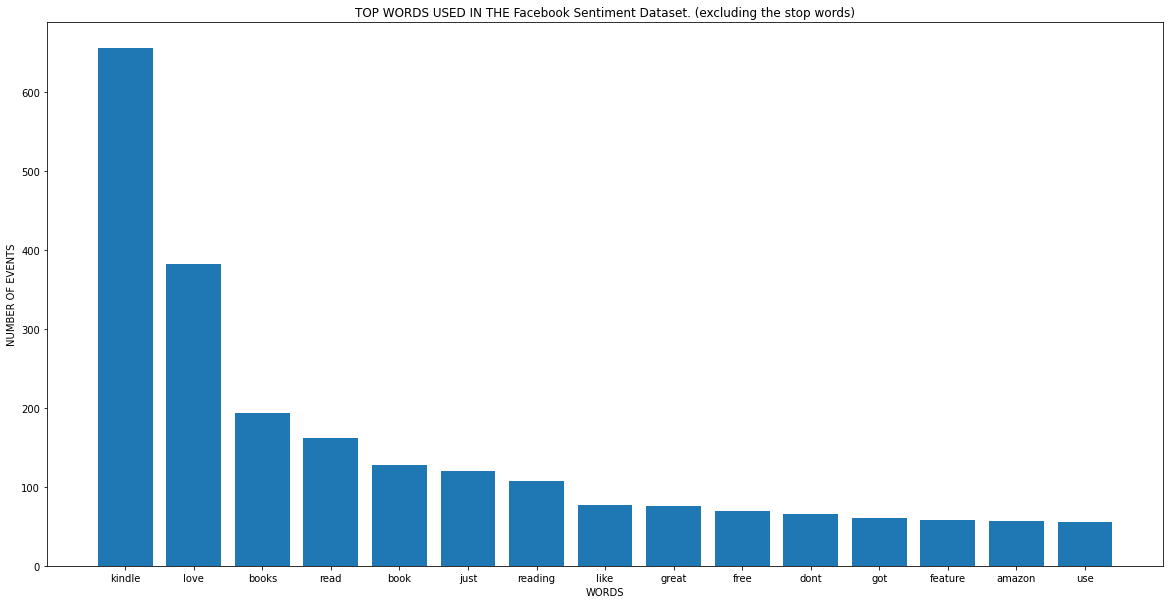

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='horizontal');
ax.set_title('TOP WORDS USED IN THE Facebook Sentiment Dataset. (excluding the stop words)');
ax.set_xlabel('WORDS');
ax.set_ylabel('NUMBER OF EVENTS');
plt.show()

In [8]:
from textblob import TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
tagged_posts = [TextBlob(data[i]).pos_tags for i in range(data.shape[0])]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
tagged_posts_df = pd.DataFrame({'tags':tagged_posts})

word_counts = [] 
pos_counts = {}

for headline in tagged_posts_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per post: ', np.mean(word_counts))

Total number of words:  22031
Mean number of words per post:  22.031


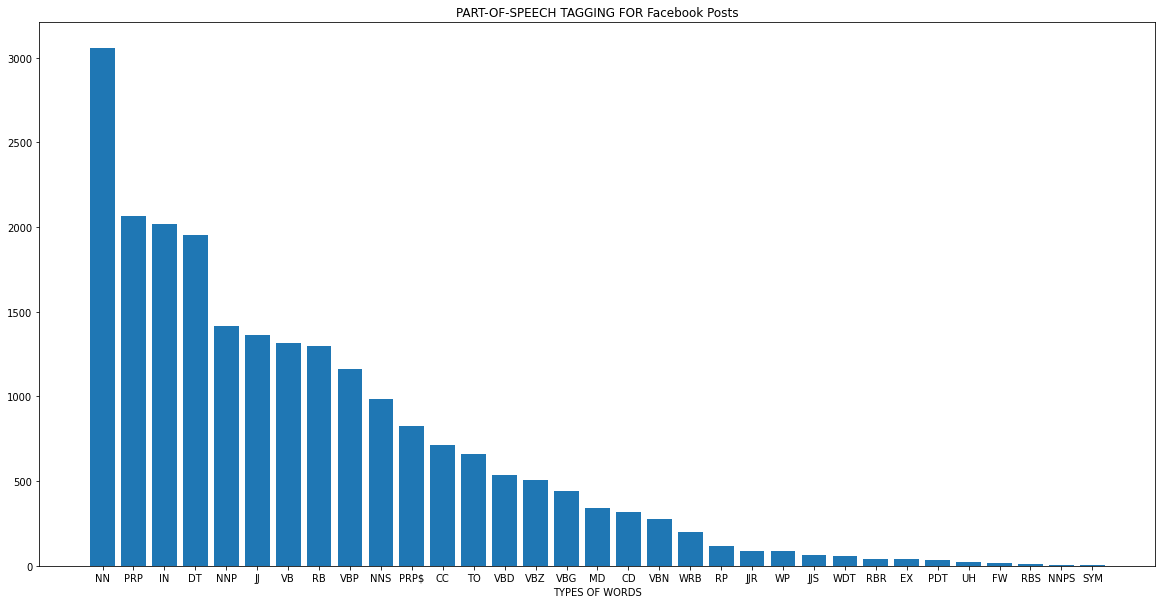

In [10]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('PART-OF-SPEECH TAGGING FOR Facebook Posts');
ax.set_xlabel('TYPES OF WORDS');

# **Pre-Processing**

In [11]:
#2- Remove emails and new line characters
def clean_FBPost(data):
    data = [re.sub('\S*http\S*\s?', '', sent) for sent in data]  # This match the address \S*http\S*\s? = \S*(all non-space characters), then finds 'http',
                                                                 #then again \S*(all non-space characters), then \s? (ends when it finds space char)
    data = [re.sub('\S*www\S*\s?', '', sent) for sent in data]
    data = [re.sub('\S*kindle\S?', '', sent) for sent in data]
    #data = [re.sub("\'", "", sent) for sent in data]
    data = [re.sub('\.*', '', sent) for sent in data]
    data = [re.sub('\@*', '', sent) for sent in data]
    data = [re.sub('\♥*', '', sent) for sent in data]
    #data = [re.sub('[%s]' % re.escape("""!"#$%&()*+,'-./:;<=>?@[\]^_`{|}~"""), '', sent) for sent in data]  # remove punctuations
    data = [re.sub('\s+', ' ', sent) for sent in data]  # remove extra whitespace
    return data
  
clean_FBPost(data[:15])

['Drug Runners and United States Senator have something to do with the Murder The State Attorney Knows NOW So Will You GET Ypur Copy TODAY',
 'Heres a single, to add, to Kindle Just read this 19th century story: "The Ghost of Round Island" Its about a man (French/American Indian) and his dog sled transporting a woman across the ice, from Mackinac Island to Cheboygan - and the ghost that',
 'If you tire of Non-Fiction Check out ',
 'Ghost of Round Island is supposedly nonfiction',
 'Why is Barnes and Nobles version of the Kindle so much more expensive than the Kindle?',
 'Maria: Do you mean the Nook? Be careful, books you buy for the Kindle are for that piece of electronics, and vice versa I love my Kindle, there are people that swear by the Nook They like the color screenMe? I want an ereader that is a reader-- so I dont need color The battery lasts longer, and the unit isnt as heavy, which can make a difference after reading for a few hours :)',
 ' is awesome! mines great',
 'I love m

In [12]:
#3- Tokenize words and clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        #Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
        #https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess
        #gensim.utils.simple_preprocess(doc, deacc=False, min_len=2, max_len=15)
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(clean_FBPost(data)))
print(data_words)

[['drug', 'runners', 'and', 'united', 'states', 'senator', 'have', 'something', 'to', 'do', 'with', 'the', 'murder', 'the', 'state', 'attorney', 'knows', 'now', 'so', 'will', 'you', 'get', 'ypur', 'copy', 'today'], ['heres', 'single', 'to', 'add', 'to', 'kindle', 'just', 'read', 'this', 'th', 'century', 'story', 'the', 'ghost', 'of', 'round', 'island', 'its', 'about', 'man', 'french', 'american', 'indian', 'and', 'his', 'dog', 'sled', 'transporting', 'woman', 'across', 'the', 'ice', 'from', 'mackinac', 'island', 'to', 'cheboygan', 'and', 'the', 'ghost', 'that'], ['if', 'you', 'tire', 'of', 'non', 'fiction', 'check', 'out'], ['ghost', 'of', 'round', 'island', 'is', 'supposedly', 'nonfiction'], ['why', 'is', 'barnes', 'and', 'nobles', 'version', 'of', 'the', 'kindle', 'so', 'much', 'more', 'expensive', 'than', 'the', 'kindle'], ['maria', 'do', 'you', 'mean', 'the', 'nook', 'be', 'careful', 'books', 'you', 'buy', 'for', 'the', 'kindle', 'are', 'for', 'that', 'piece', 'of', 'electronics', 

In [13]:
#4- Create Bigram & Trigram Models
bigram = gensim.models.Phrases(data_words, min_count=1.9, threshold=150)
trigram = gensim.models.Phrases(bigram[data_words], threshold=150)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [14]:
#5- Remove stopwords, Make Bigrams and Lemmatize
def processed_words(text, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text]
    print(type(text))
    text = [bigram_mod[doc] for doc in text]
    text = [trigram_mod[bigram_mod[doc]] for doc in text]
    texts_out = []
    nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
    print(type(nlp))
    for sent in text:
        doc = nlp(" ".join(sent)) 
        #[print(token, token.lemma, token.lemma_, token.pos_) for token in doc]  #collections 9613535637429559193 collection NOUN
                                                                                #drug_runners 14544042934281175508 drug_runners PROPN
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = processed_words(data_words)

<class 'list'>
<class 'spacy.lang.en.English'>


In [15]:
print(data_ready) # processed Text Data!

[['senator', 'murder', 'copy', 'today'], ['single', 'add', 'century', 'story', 'ghost', 'man', 'french', 'indian', 'sle', 'transport', 'woman', 'ghost'], ['fiction', 'check'], ['supposedly', 'nonfiction'], ['version', 'kindle', 'expensive'], ['mean', 'careful', 'buy', 'piece', 'electronic', 'swear', 'reader', 'color', 'battery', 'last', 'unit', 'heavy', 'difference', 'hour'], ['awesome'], [], ['single', 'bad', 'idea', 'big', 'name', 'author', 'dominate', 'market', 'huge', 'factor', 'let', 'compete', 'price', 'point', 'indie', 'author', 'less', 'content', 'money'], ['daughter'], ['update', 'location', 'number', 'press', 'page', 'number', 'wrong'], ['reader', 'fun'], ['patience', 'single', 'least', 'page'], [], ['fan', 'single', 'clog', 'kindle', 'page', 'tough', 'sort', 'full', 'legnth', 'release', 'single'], [], [], ['free', 'chapter', 'tick', 'summary', 'chapter', 'real', 'jump', 'page', 'real', 'big'], ['provoke'], ['hard', 'choose'], ['single'], ['mood'], ['difference', 'color', 'co

In [16]:
#Dictionary Creation
id2word = Dictionary(data_ready)
id2word.filter_extremes(no_below=2)
print(len(id2word))
print(type(data_ready))
print(id2word)

696
<class 'list'>
Dictionary(696 unique tokens: ['copy', 'today', 'add', 'french', 'man']...)


In [17]:
#Create Corpus
#Term Frequency in Document
corpus = [id2word.doc2bow(text)for text in data_ready]
print(corpus)

# Human readable format of corpus (term-frequency)
print([[(id2word[id], freq)for id,freq in cp]for cp in corpus])

[[(0, 1), (1, 1)], [(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1)], [], [(9, 1), (10, 1), (11, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)], [(23, 1)], [], [(5, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)], [(36, 1)], [(37, 2), (38, 1), (39, 1), (40, 1), (41, 1)], [(22, 1), (42, 1)], [(5, 1), (38, 1), (43, 1)], [], [(5, 2), (10, 1), (38, 1), (44, 1), (45, 1), (46, 1), (47, 1)], [], [], [(26, 1), (38, 1), (48, 2), (49, 1), (50, 1), (51, 2)], [], [(52, 1), (53, 1)], [(5, 1)], [], [(5, 1), (10, 1), (15, 2), (16, 1), (44, 1), (54, 1), (55, 1), (56, 1)], [(10, 1), (25, 1), (57, 1), (58, 1), (59, 1), (60, 1)], [], [(0, 1), (1, 1), (61, 1), (62, 1)], [(63, 1), (64, 1)], [(63, 1), (65, 1), (66, 1)], [(32, 1), (49, 1)], [(31, 1), (50, 1), (67, 1)], [(32, 1), (68, 1), (69, 1)], [(70, 1), (71, 1)], [(56, 1), (63, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1),

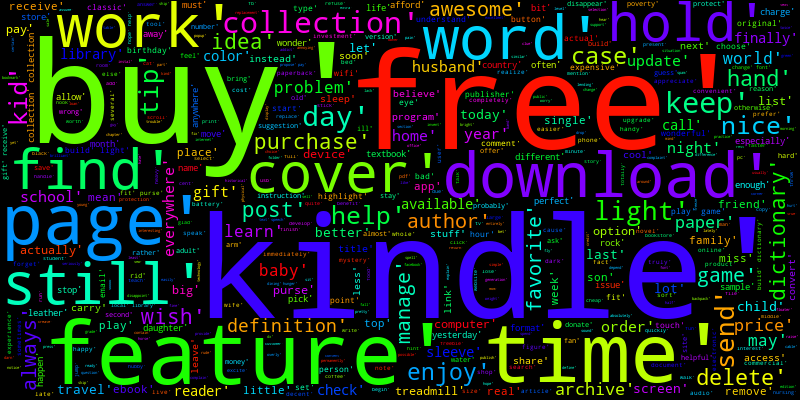

In [18]:
# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color="black", max_words=5000, 
                      contour_width=5, contour_color='grey', colormap="gist_rainbow",  
                      random_state=10)#.generate(str(raw_data['FBPost']))
#wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=5, contour_color='grey')

# Generate a word cloud
wordcloud.generate(str(data_ready))

# Visualize the word cloud
wordcloud.to_image()

# **LDA Modelling & Analysis**

In [19]:
#7- Building LDA Model
num_topics = 8
lda_Model_build = gensim.models.ldamodel.LdaModel(corpus= corpus, id2word= id2word, num_topics=num_topics,
                                                  random_state=100, update_every=1, chunksize=100,
                                                  passes=10, alpha= 'auto', eta='auto',
                                                  per_word_topics=True)
pd.DataFrame(lda_Model_build.print_topics())

,0,1
0,0,"0.067*""kid"" + 0.059*""dictionary"" + 0.033*""cove..."
1,1,"0.082*""free"" + 0.075*""find"" + 0.060*""buy"" + 0...."
2,2,"0.098*""time"" + 0.060*""hold"" + 0.047*""word"" + 0..."
3,3,"0.070*""light"" + 0.044*""kindle"" + 0.044*""build""..."
4,4,"0.044*""work"" + 0.044*""kindle"" + 0.042*""send"" +..."
5,5,"0.121*""page"" + 0.053*""always"" + 0.036*""enjoy"" ..."
6,6,"0.069*""idea"" + 0.039*""year"" + 0.037*""manage"" +..."
7,7,"0.165*""feature"" + 0.055*""tip"" + 0.050*""day"" + ..."


In [20]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        #print(words)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [21]:
get_lda_topics(lda_Model_build, num_topics)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08
0,kid,free,time,light,work,page,idea,feature
1,dictionary,find,hold,kindle,kindle,always,year,tip
2,cover,buy,word,build,send,enjoy,manage,day
3,word,available,school,still,help,son,download,collection
4,paper,mean,keep,case,nice,country,buy,definition
5,favorite,child,everywhere,baby,learn,home,author,may
6,issue,afford,reader,cover,post,link,family,actually
7,instead,archive,awesome,night,hand,live,point,life
8,buy,call,charge,buy,wish,update,friend,screen
9,device,purchase,finally,check,gift,email,option,today


In [22]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df2 = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df2 = sent_topics_df2.append(pd.Series([int(topic_num), round(prop_topic,9), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df2.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

   # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df1 = pd.concat([sent_topics_df2, contents], axis=1)
    return(sent_topics_df2)

In [23]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_Model_build, corpus=corpus, texts=data_ready)

In [24]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,7.0,0.501496,"feature, tip, day, collection, definition, may..."
1,2.0,0.617726,"time, hold, word, school, keep, everywhere, re..."
2,3.0,0.355475,"light, kindle, build, still, case, baby, cover..."
3,4.0,0.211110,"work, kindle, send, help, nice, learn, post, h..."
4,4.0,0.627214,"work, kindle, send, help, nice, learn, post, h..."
...,...,...,...
995,0.0,0.495054,"kid, dictionary, cover, word, paper, favorite,..."
996,6.0,0.413386,"idea, year, manage, download, buy, author, fam..."
997,3.0,0.355475,"light, kindle, build, still, case, baby, cover..."
998,2.0,0.271294,"time, hold, word, school, keep, everywhere, re..."


In [25]:
contents = pd.Series(data)
df_topic_sents_keywords = pd.concat([df_topic_sents_keywords, contents], axis=1)

In [26]:
df_topic_sents_keywords 

,Dominant_Topic,Perc_Contribution,Topic_Keywords,FBPost
0,7.0,0.501496,"feature, tip, day, collection, definition, may...",Drug Runners and United States Senator have s...
1,2.0,0.617726,"time, hold, word, school, keep, everywhere, re...","Heres a single, to add, to Kindle. Just read t..."
2,3.0,0.355475,"light, kindle, build, still, case, baby, cover...",If you tire of Non-Fiction.. Check out http://...
3,4.0,0.211110,"work, kindle, send, help, nice, learn, post, h...",Ghost of Round Island is supposedly nonfiction.
4,4.0,0.627214,"work, kindle, send, help, nice, learn, post, h...",Why is Barnes and Nobles version of the Kindle...
...,...,...,...,...
995,0.0,0.495054,"kid, dictionary, cover, word, paper, favorite,...",I liked it. Its youth oriented and I think th...
996,6.0,0.413386,"idea, year, manage, download, buy, author, fam...","I think the point of the commercial is that, e..."
997,3.0,0.355475,"light, kindle, build, still, case, baby, cover...",Kindle 3 is such a great product. I could not ...
998,2.0,0.271294,"time, hold, word, school, keep, everywhere, re...",develop a way to share books! that is a big d...


In [27]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.501496,"feature, tip, day, collection, definition, may...",Drug Runners and United States Senator have s...
1,1,2.0,0.617726,"time, hold, word, school, keep, everywhere, re...","Heres a single, to add, to Kindle. Just read t..."
2,2,3.0,0.355475,"light, kindle, build, still, case, baby, cover...",If you tire of Non-Fiction.. Check out http://...
3,3,4.0,0.211110,"work, kindle, send, help, nice, learn, post, h...",Ghost of Round Island is supposedly nonfiction.
4,4,4.0,0.627214,"work, kindle, send, help, nice, learn, post, h...",Why is Barnes and Nobles version of the Kindle...
5,5,1.0,0.678455,"free, find, buy, available, mean, child, affor...","@Maria: Do you mean the Nook? Be careful, bo..."
6,6,2.0,0.368699,"time, hold, word, school, keep, everywhere, re...",kindle is awesome! mines great
7,7,4.0,0.211110,"work, kindle, send, help, nice, learn, post, h...",I love mine!!!!
8,8,6.0,0.555238,"idea, year, manage, download, buy, author, fam...",Meh. I think Singles are a bad idea. Big name ...
9,9,5.0,0.340411,"page, always, enjoy, son, country, home, link,...",My daughter loves hers!


In [28]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], #play around with .head() and observe changes 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.756018,"kid, dictionary, cover, word, paper, favorite, issue, instead, buy, device","I MADE myself a cover and it sure dint cost me 20 bucks! An being that I am a HORSE person , ..."
1,1.0,0.728475,"free, find, buy, available, mean, child, afford, archive, call, purchase","@Cara Bolton. Unfortunately, you have to re-purchase them, which I just did yesterday with three..."
2,2.0,0.617726,"time, hold, word, school, keep, everywhere, reader, awesome, charge, finally","Heres a single, to add, to Kindle. Just read this 19th century story: ""The Ghost of Round Island..."
3,3.0,0.796099,"light, kindle, build, still, case, baby, cover, night, buy, check","If you dont like the games, dont buy them. I have a few games and its fun to be able to play a f..."
4,4.0,0.782786,"work, kindle, send, help, nice, learn, post, hand, wish, gift",My kindle was a late Christmas gift to myself. I truly believe is the greatest invention since p...
5,5.0,0.721248,"page, always, enjoy, son, country, home, link, live, update, email",I am not sure if i just got my update but now i dont have location numbers unless i press the me...
6,6.0,0.715807,"idea, year, manage, download, buy, author, family, point, friend, option",I bought Kindles for 2 sisters who love to read. They were so excited. Shortly afterwards a frie...
7,7.0,0.712630,"feature, tip, day, collection, definition, may, actually, life, screen, today","Agreed collections contain books, but the books are also contained outside of the collection fol..."


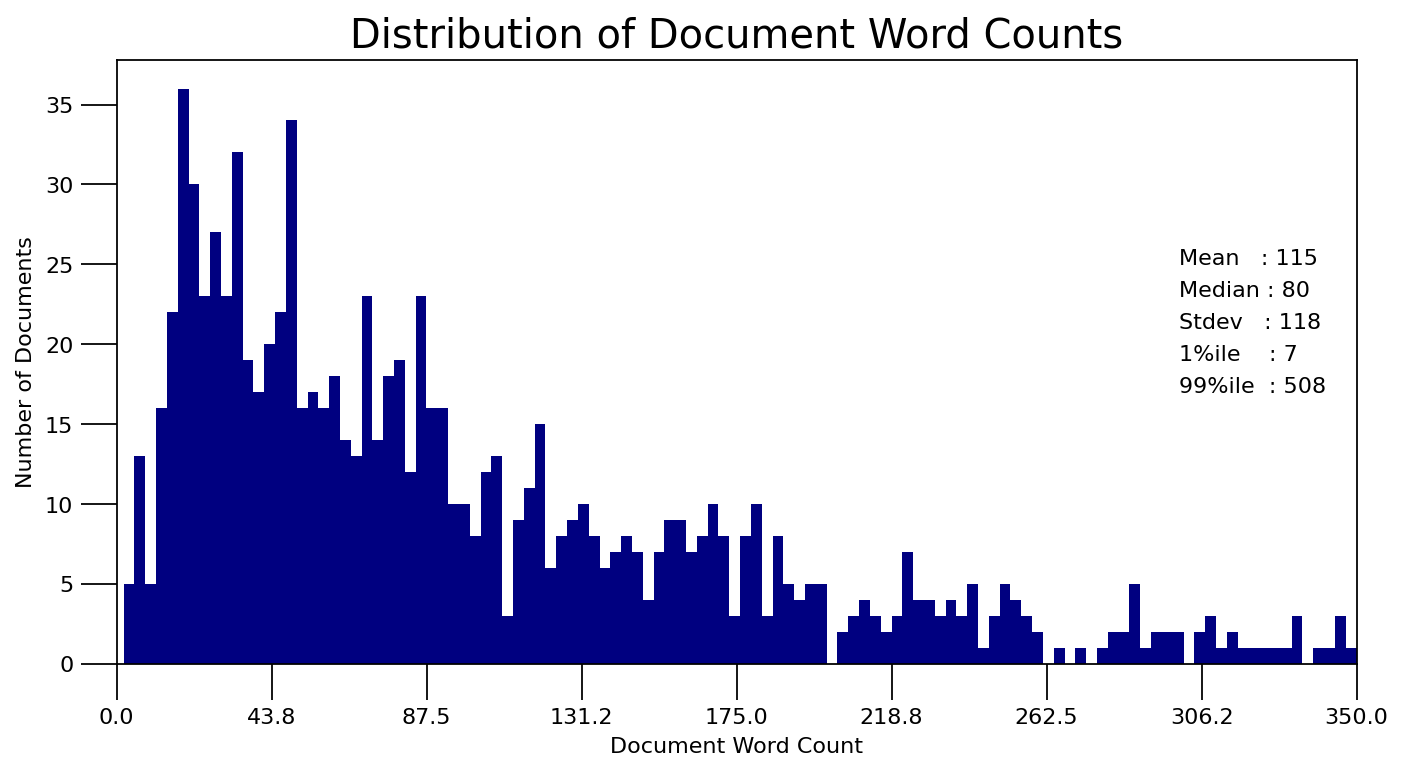

In [29]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,5), dpi=160)
plt.hist(doc_lens, bins = 400, color='navy')
plt.text(300, 25, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(300,  23, "Median : " + str(round(np.median(doc_lens))))
plt.text(300,  21, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(300,  19, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(300,  17, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 350), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,350,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=18))
plt.show()

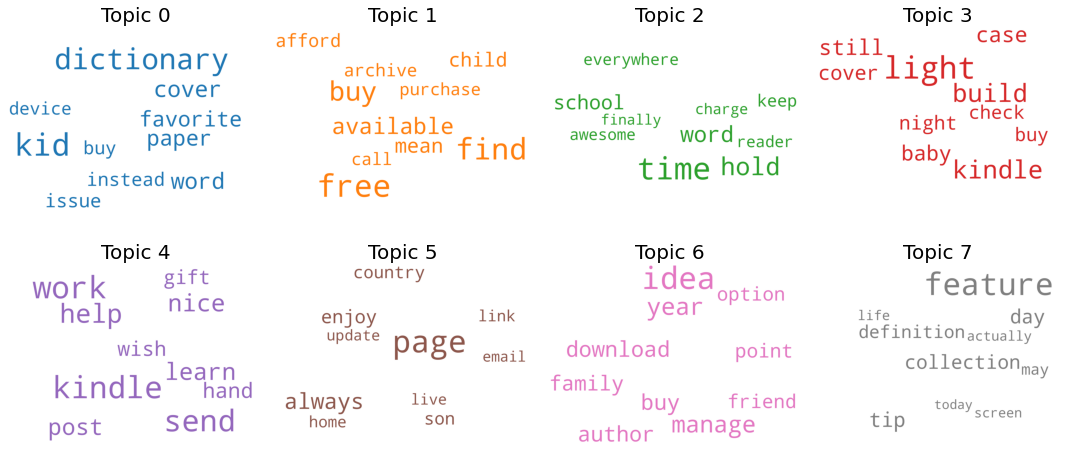

In [30]:
# Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_Model_build.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(15,7), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

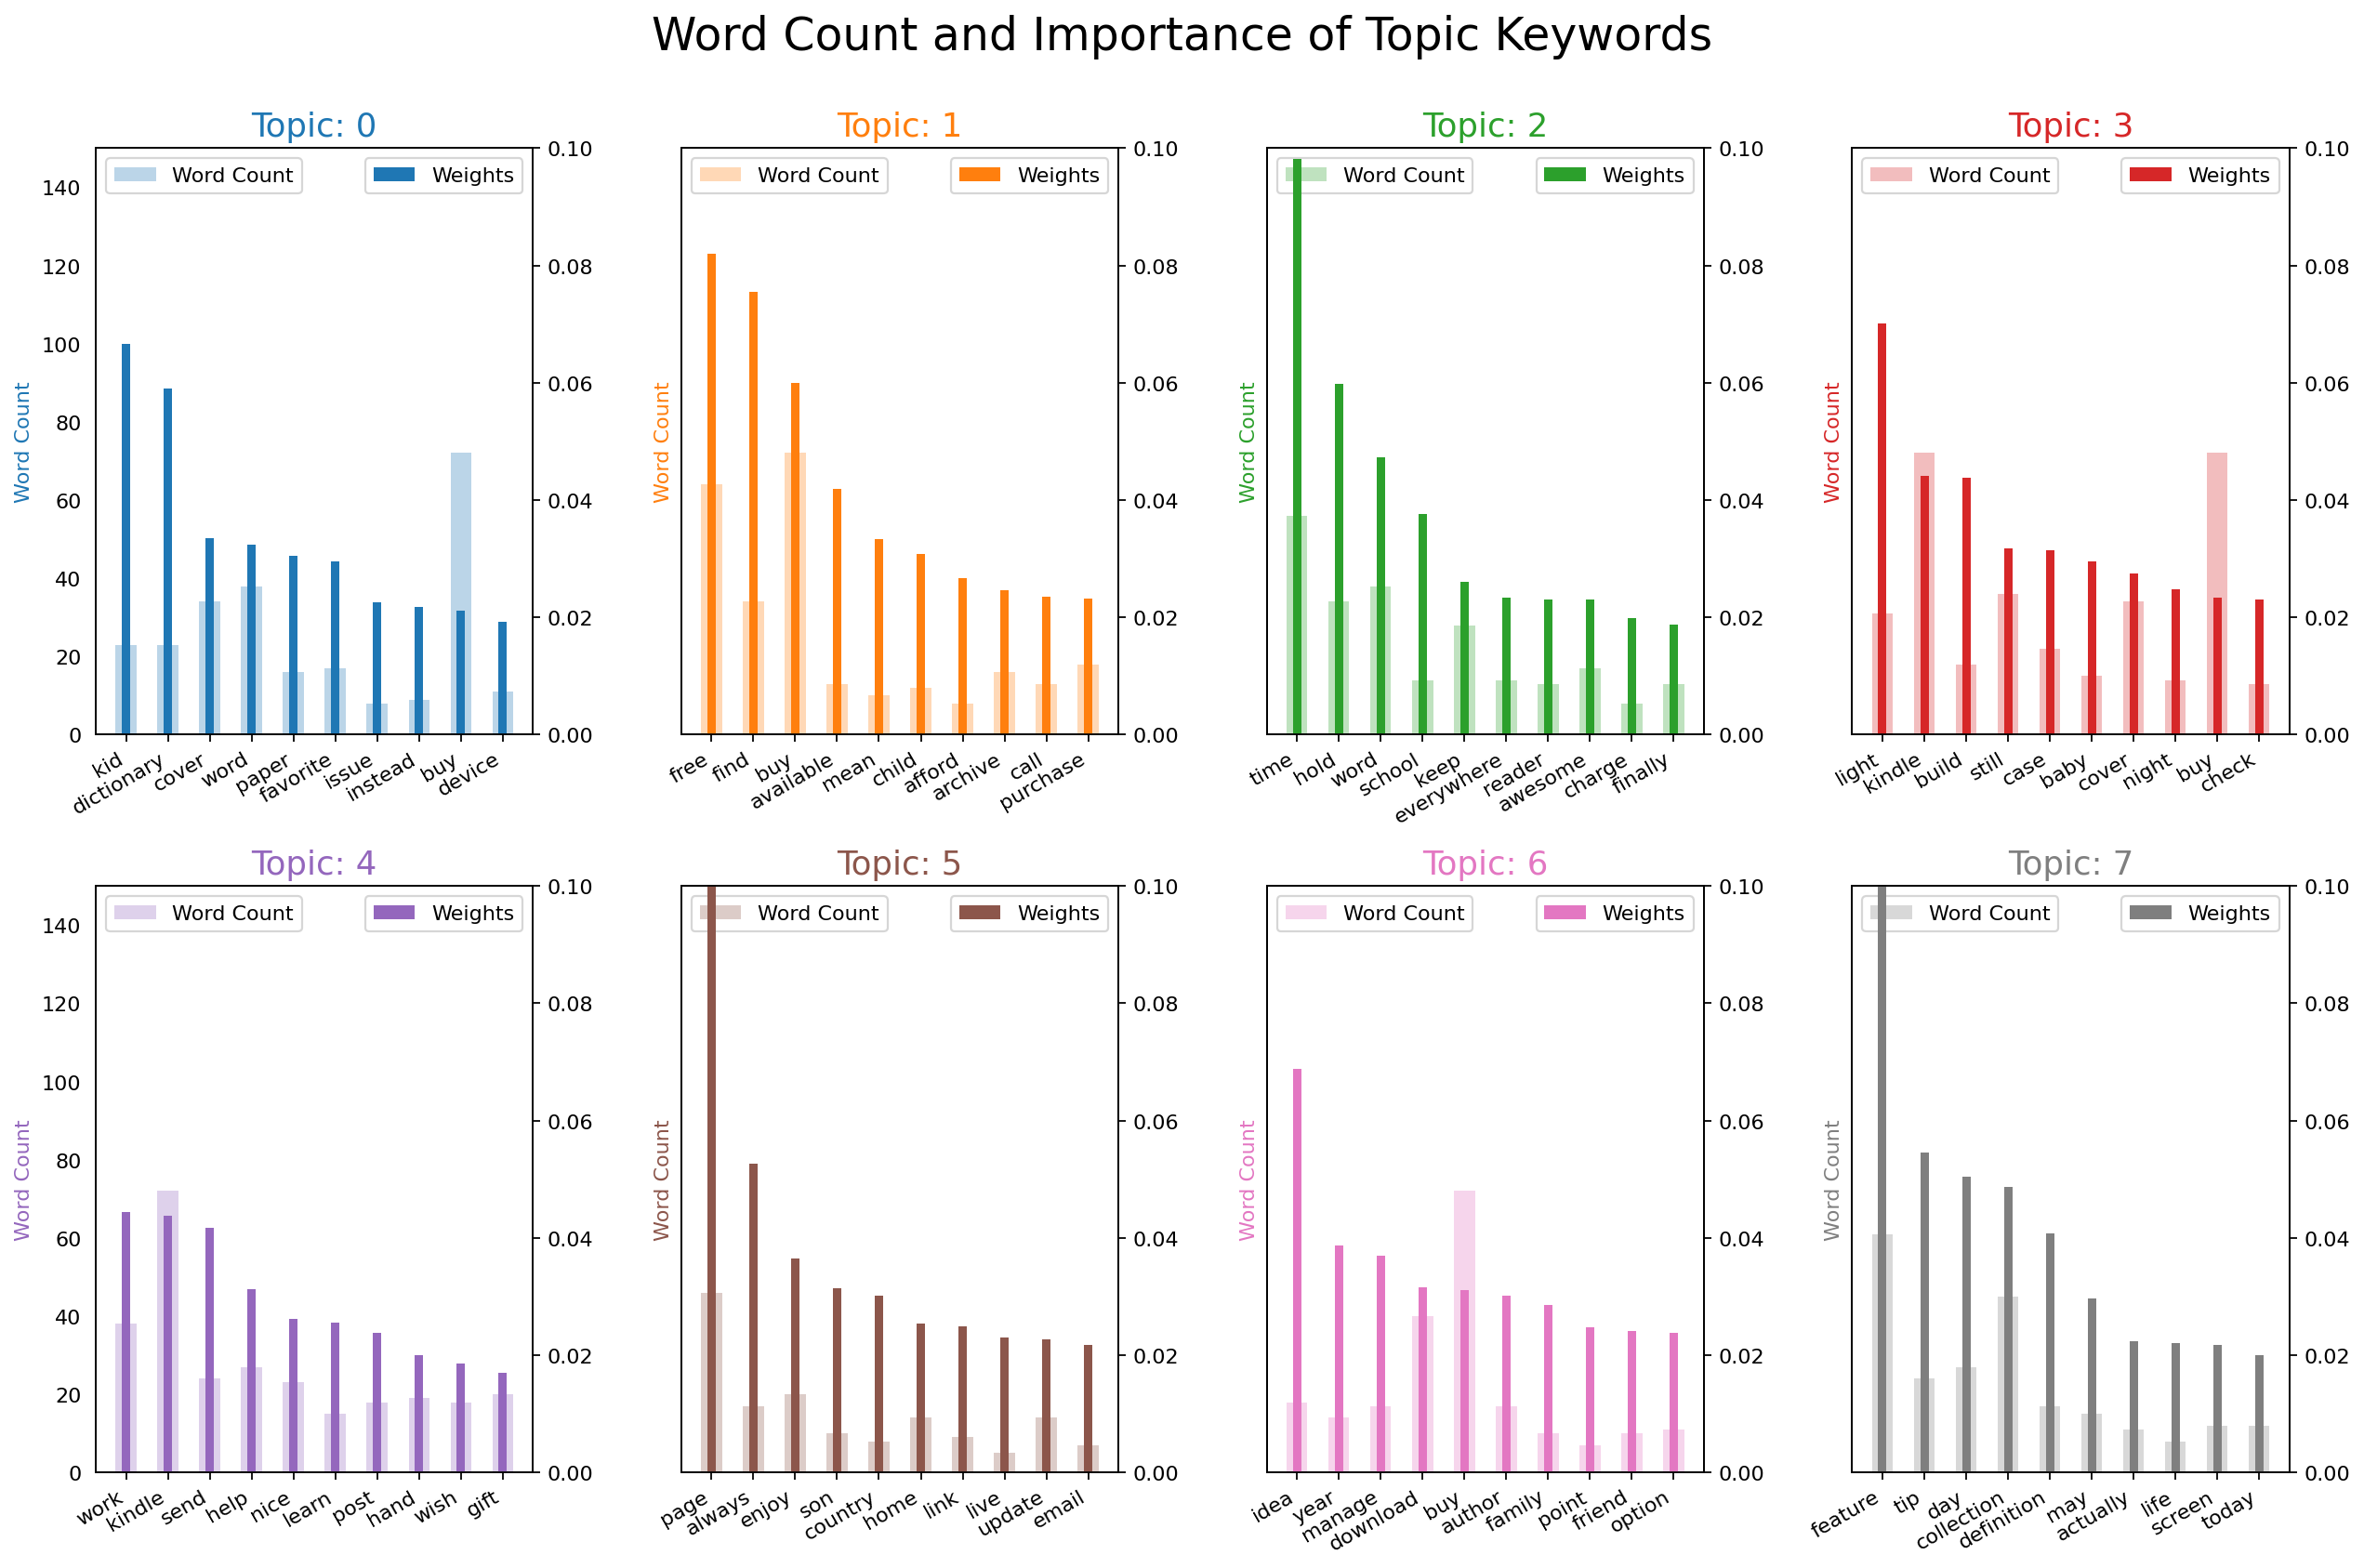

In [31]:
from collections import Counter
topics = lda_Model_build.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.100); ax.set_ylim(0, 150)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [32]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_Model_build, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_Model_build.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


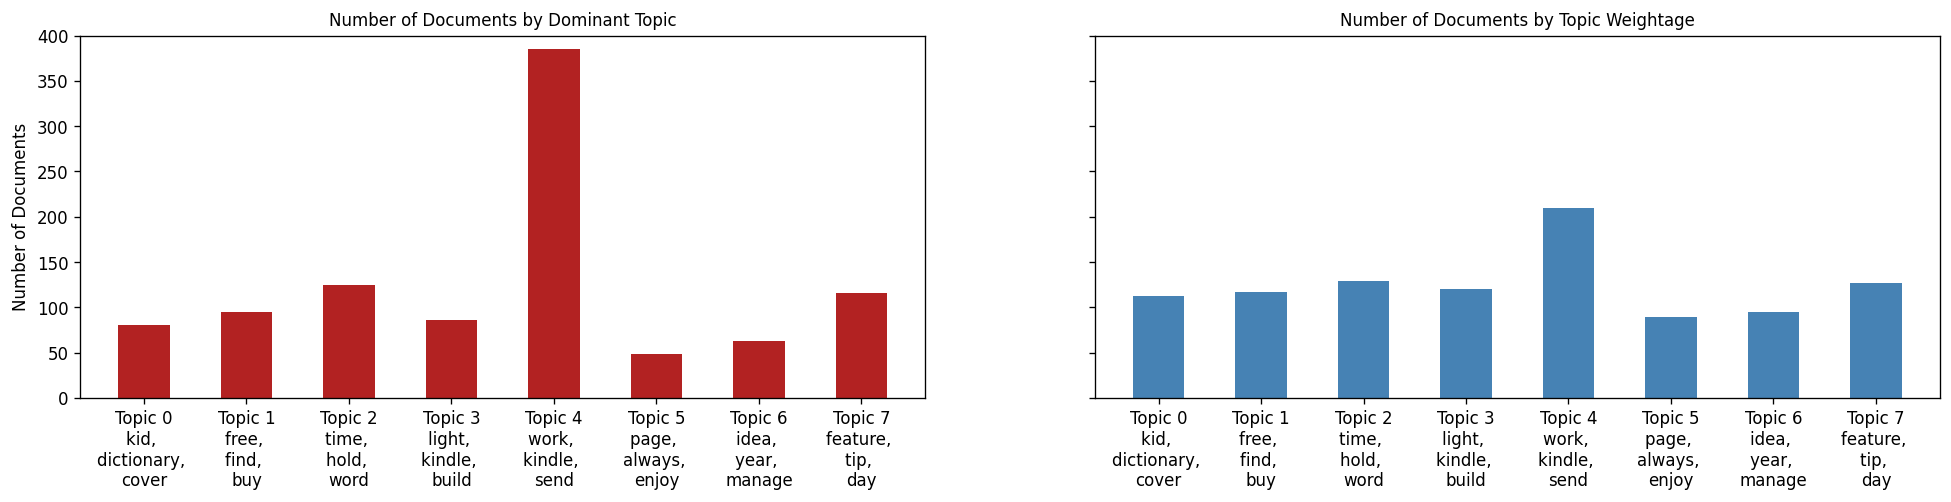

In [33]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 400)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=0.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [34]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_Model_build[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = num_topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 556 samples in 0.001s...
[t-SNE] Computed neighbors for 556 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 556 / 556
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.010559
[t-SNE] KL divergence after 1000 iterations: 0.247655


In [35]:
#Intertopic Distance Map using pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_Model_build, corpus, dictionary=lda_Model_build.id2word)
pyLDAvis.save_html(vis, 'pyLDAvis Intertopic Mapping of 8 LDA topics.html')
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.286704 -0.199506       1        1  21.714038
3     -0.198575  0.047951       2        1  12.625246
2      0.155003 -0.066253       3        1  12.410193
1      0.014066  0.154522       4        1  12.006617
7      0.196417 -0.248473       5        1  11.358002
0      0.072691  0.172396       6        1  10.899452
6     -0.013912  0.157645       7        1   9.769837
5      0.061016 -0.018282       8        1   9.216615, topic_info=            Term       Freq      Total Category  logprob  loglift
393      feature  77.000000  77.000000  Default  30.0000  30.0000
38          page  46.000000  46.000000  Default  29.0000  29.0000
56          time  50.000000  50.000000  Default  28.0000  28.0000
49          free  40.000000  40.000000  Default  27.0000  27.0000
204         find  37.000000  37.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
417         spam   3.992422   4.356384   Topic8  -4.5514   2.2969
589    seriously   4.037596   4.409376   Topic8  -4.5401   2.2961
282  instruction   4.063217   4.453661   Topic8  -4.5338   2.2924
597      morning   3.727092   4.087012   Topic8  -4.6202   2.2920
119          old   4.001095   4.387662   Topic8  -4.5492   2.2919

[301 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
232       1  0.902972     access
360       4  0.823111     actual
72        5  0.922090   actually
692       2  0.935091         ad
180       6  0.952057      adult
...     ...       ...        ...
293       3  0.381479      world
171       6  0.933342      write
41        8  0.932307      wrong
189       7  1.002863       year
147       4  0.939316  yesterday

[280 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 8, 1, 7, 6])

# **# LSA Analysis**

In [36]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
import nltk
nltk.download('stopwords')


%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
datafile = '/content/drive/MyDrive/Colab Notebooks/7135CEM/Topic Modelling_LDA_LSA/fb_sentiment.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['FBPost']
raw_data.head()

,Unnamed: 0,FBPost,Label
0,0,Drug Runners and United States Senator have something to do with the Murder http://www.amazon.c...,O
1,1,"Heres a single, to add, to Kindle. Just read this 19th century story: ""The Ghost of Round Island...",O
2,2,If you tire of Non-Fiction.. Check out http://www.amazon.com/s/ref=nb_sb_noss?url=search-alias%3...,O
3,3,Ghost of Round Island is supposedly nonfiction.,O
4,4,Why is Barnes and Nobles version of the Kindle so much more expensive than the Kindle?,N


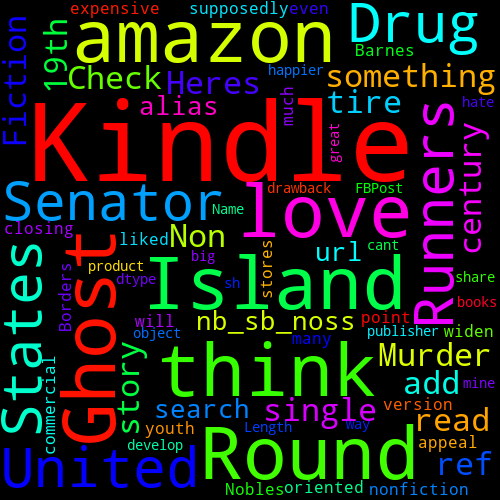

In [38]:
# Create a WordCloud object
wordcloud = WordCloud(width = 500, height = 500, background_color="black", max_words=5000, 
                      contour_width=5, contour_color='grey', colormap="gist_rainbow",  
                      random_state=10)#.generate(str(raw_data['FBPost']))
#wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=5, contour_color='grey')

# Generate a word cloud
wordcloud.generate(str(raw_data['FBPost']))

# Visualize the word cloud
wordcloud.to_image()


In [39]:
small_count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=40000)
small_text_sample = reindexed_data.sample(n=1000, random_state=0).values
print(small_text_sample)
print('Facebook Post before vectorization: {}'.format(small_text_sample[3]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)
# print(small_document_term_matrix)
print('Facebook Post after vectorization: \n{}'.format(small_document_term_matrix[3]))

['Love my Kindle3 + the cover with light. Waiting to buy DX when Wi-fi available.'
 'I use an inexpensive led light that straps onto me head with an elastic band, and runs on AA batteries. The light can be used for other things too, not just to light up me Kindle.'
 'THANK YOU! Finally.'
 'I LOVE my kindle. Just got my awesome case w/ built in light yesterday! Love that too. =)'
 'i love this feature!  I also use it to see if Im right when "guessing" the definition of a word.  Very cool!'
 'Well been comparing Kindle with Color Nook and well really would like that Color Nook'
 'I have a couple games on my kindle...only problem is my family seems to think I put them on there for them...'
 'I Love my Kindle. I like trying out the Free Books,  BUT, your Free Books selections are POOR!  And the Free Book Section is Not Updated Hourly!  I paid for my Kindle, So I do wish that the price of the Kindle books were reduced for Kindle owners!!!Kindle, How about a response to this.'
 'Melodie - ho

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['kindle'] not in stop_words.
  % sorted(inconsistent)


In [40]:
n_topics = 9

In [41]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)
# lsa_topic_matrix

In [42]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [43]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [44]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('utf-8').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words


In [45]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  kindle like time free bought amazon since still cant download
Topic 2:  kids cant wanna afford kindle water food fat poverty sick
Topic 3:  word page feature dictionary tip definition move wanted button work
Topic 4:  free amazon thats time downloaded games library etc word tips
Topic 5:  feature dictionary better work hard baby kindle perfect american please
Topic 6:  light cover built amazon bought collection easier kindle using screen
Topic 7:  like collections collection games buy play night without fun inside
Topic 8:  years aloha worth nonfiction liked receive dearly widen island daughter
Topic 9:  title download remove highlight still click collections archives device helps


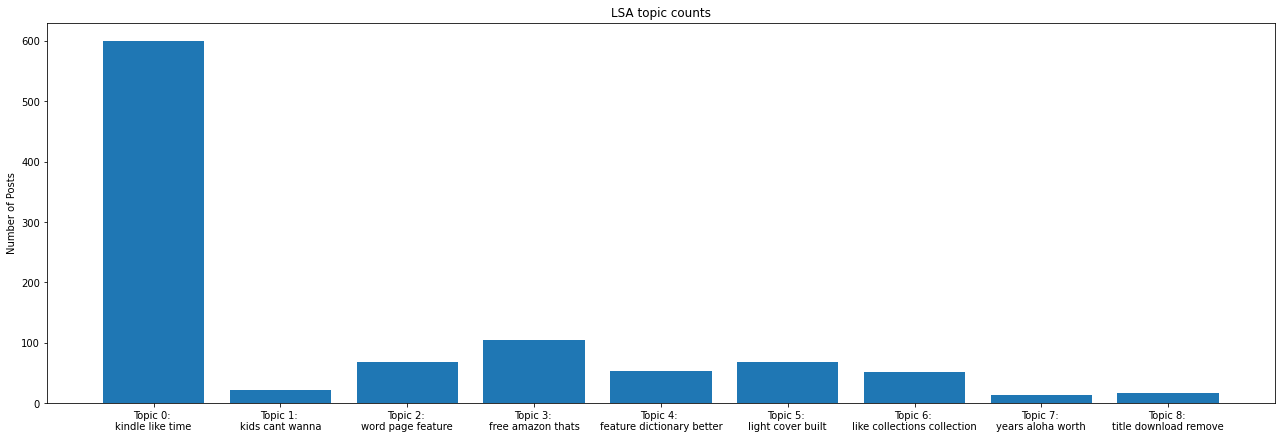

In [46]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of Posts');
ax.set_title('LSA topic counts');
plt.show()

In [47]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.899803
[t-SNE] KL divergence after 2000 iterations: 0.444805


In [48]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [49]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [50]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)